Experiment 1:
Objectives:
  1. Combine Gemma and ViT and figure out how to use/train/test the whole model
  2. Get The data pipeline for training and testing working.

In [1]:
from google.colab import drive

drive.mount("./drive")

Mounted at ./drive


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoImageProcessor, AutoModel


device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else 'cpu'
device

device(type='cuda')

In [3]:
gemma_id = "google/gemma-3-270m"
vit_id = "facebook/dinov3-vits16plus-pretrain-lvd1689m"

gemma_tokenizer = AutoTokenizer.from_pretrained(gemma_id)
vit_tokenizer = AutoImageProcessor.from_pretrained(vit_id)

gemma = AutoModelForCausalLM.from_pretrained(
    gemma_id,
    dtype=torch.float32,
    device_map = "auto",
    attn_implementation = "eager",
).to(device)

vit = AutoModel.from_pretrained(
    vit_id,
    dtype=torch.float32,
    device_map = "auto",
    attn_implementation = "eager",
).to(device)

for parameter in vit.parameters():
    parameter.requires_grad = False

gemma_embed_size =  gemma.get_input_embeddings().weight.shape[1]
vit_embed_size = vit.config.hidden_size

mlp_adapter = nn.Sequential(
    nn.LayerNorm(vit_embed_size),
    nn.Linear(vit_embed_size, gemma_embed_size),
    nn.GELU(approximate='tanh'),
    nn.Linear(gemma_embed_size, gemma_embed_size)
).to(device) # from internVL3

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
def prepare_inputs(images, captions):
    with torch.no_grad():
        vit_out = vit(images)

    image_embed = mlp_adapter(vit_out)

    tok = gemma_tokenizer(captions, return_tensors='pt', padding=True)
    input_ids = tok["input_ids"].to(device)
    attention_mask = tok["attention_mask"].to(device)

    input_embeds = gemma.get_input_embeddings()(input_ids)
    bs, num_txt_tok, gem_dim = input_embeds.shape
    num_img_tok = image_embed.shape[1]

    new_embeds = torch.cat([image_embed, input_embeds], dim=1) # (bs, img_tok+txt_tok, gem_dim)
    new_mask = torch.cat([torch.ones(bs, num_img_tok, device=device), attention_mask], dim=1) #(bs, img_tok+txt_tok, gem_dim) with all img_tok visible at all times

    return new_embeds, new_mask, input_ids, num_img_tok

In [5]:
import os

os.environ["HF_DATASETS_CACHE"] = "/content/drive/MyDrive/hf_datasets"

In [6]:
from datasets import load_dataset

dataset = load_dataset("Multimodal-Fatima/COCO_captions_train")

README.md:   0%|          | 0.00/758 [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/38 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/30 [00:00<?, ?it/s]

In [7]:
dataset["train"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480>,
 'filepath': 'COCO_val2014_000000522418.jpg',
 'sentids': [681330, 686718, 688839, 693159, 693204],
 'filename': 'COCO_val2014_000000522418.jpg',
 'imgid': 1,
 'split': 'restval',
 'sentences_tokens': [['a',
   'woman',
   'wearing',
   'a',
   'net',
   'on',
   'her',
   'head',
   'cutting',
   'a',
   'cake'],
  ['a', 'woman', 'cutting', 'a', 'large', 'white', 'sheet', 'cake'],
  ['a',
   'woman',
   'wearing',
   'a',
   'hair',
   'net',
   'cutting',
   'a',
   'large',
   'sheet',
   'cake'],
  ['there', 'is', 'a', 'woman', 'that', 'is', 'cutting', 'a', 'white', 'cake'],
  ['a',
   'woman',
   'marking',
   'a',
   'cake',
   'with',
   'the',
   'back',
   'of',
   'a',
   'chefs',
   'knife']],
 'sentences_raw': ['A woman wearing a net on her head cutting a cake. ',
  'A woman cutting a large white sheet cake.',
  'A woman wearing a hair net cutting a large sheet cake.',
  'there is a woman that is cut

In [8]:
# 1) Check device and models
print("device:", device)
print("gemma model:", gemma.__class__.__name__, "embedding dim:", gemma.get_input_embeddings().weight.shape)
# For ViT, inspect config/outputs
print("vit type:", type(vit))
print("vit config:", getattr(vit, "config", None))

# 2) Build a tiny dummy image batch from the image processor (or a real sample from your dataset)
from PIL import Image
import numpy as np

# create dummy image(s) (RGB)
dummy = Image.new("RGB", (224,224), color=(128,128,128))
proc = vit_tokenizer  # AutoImageProcessor
x = proc(images=[dummy, dummy], return_tensors="pt")  # batch of 2
imgs = x["pixel_values"]  # shape (B, C, H, W)
print("pixel_values shape:", imgs.shape)

# move to device
imgs = imgs.to(device)

# 3) Forward pass through vit to inspect outputs
vit.eval()
with torch.no_grad():
    vit_out = vit(imgs)               # AutoModel outputs might be BaseModelOutput
print("vit_out type:", type(vit_out))
# try standard places:
if hasattr(vit_out, "last_hidden_state"):
    vfeat = vit_out.last_hidden_state
    print("last_hidden_state shape:", vfeat.shape)
elif hasattr(vit_out, "pooler_output"):
    vfeat = vit_out.pooler_output.unsqueeze(1)
    print("pooler_output shape -> expanded:", vfeat.shape)
else:
    # try direct tensor
    print("vit_out repr:", vit_out)
    try:
        print("vit_out.shape:", vit_out.shape)
    except:
        pass

# 4) run through mlp_adapter if dims align
try:
    z = mlp_adapter(vfeat)
    print("mlp_adapter output shape:", z.shape)
except Exception as e:
    print("mlp_adapter error:", e)


device: cuda
gemma model: Gemma3ForCausalLM embedding dim: torch.Size([262144, 640])
vit type: <class 'transformers.models.dinov3_vit.modeling_dinov3_vit.DINOv3ViTModel'>
vit config: DINOv3ViTConfig {
  "architectures": [
    "DINOv3ViTModel"
  ],
  "attention_dropout": 0.0,
  "drop_path_rate": 0.0,
  "dtype": "float32",
  "hidden_act": "silu",
  "hidden_size": 384,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "key_bias": false,
  "layer_norm_eps": 1e-05,
  "layerscale_value": 1.0,
  "mlp_bias": true,
  "model_type": "dinov3_vit",
  "num_attention_heads": 6,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "num_register_tokens": 4,
  "patch_size": 16,
  "pos_embed_jitter": null,
  "pos_embed_rescale": 2.0,
  "pos_embed_shift": null,
  "proj_bias": true,
  "query_bias": true,
  "rope_theta": 100.0,
  "transformers_version": "4.56.1",
  "use_gated_mlp": true,
  "value_bias": true
}

pixel_values shape: torch.Size([2, 3, 224, 224])
vit_out type: <class

In [ ]:
# choose adapter: replace the name if using pool_adapter or linear_adapter
adapter = mlp_adapter   # or pool_adapter, or linear_adapter

# tiny batch
from PIL import Image
dummy = Image.new("RGB", (224,224), color=(128,128,128))
inputs = vit_tokenizer(images=[dummy, dummy], return_tensors="pt")["pixel_values"].to(device)  # bs = 2
B = inputs.shape[0]

# forward ViT
vit.eval()
with torch.no_grad():
    vit_out = vit(inputs)   # BaseModelOutputWithPooling
# get token embeddings (last_hidden_state)
vfeat = vit_out.last_hidden_state   # (B, P, 384)
print("vfeat.shape:", vfeat.shape)

# project
adapter.eval()
with torch.no_grad():
    proj = adapter(vfeat)   # If PoolAdapter: (B, num_prefix, 640). If MLPAdapter/Linear: (B, P, 640)
print("proj.shape:", proj.shape)

# prepare text tokens
captions = ["a gray square", "a gray square"]
tok = gemma_tokenizer(captions, return_tensors="pt", padding=True)   # make sure you have gemma_tokenizer defined
input_ids = tok["input_ids"].to(device)
att_mask = tok["attention_mask"].to(device)
input_embeds = gemma.get_input_embeddings()(input_ids)   # (B, T, E)
print("input_embeds.shape:", input_embeds.shape)

# If proj has P' tokens, concatenate them as prefix
new_embeds = torch.cat([proj, input_embeds], dim=1)
new_mask = torch.cat([torch.ones(B, proj.shape[1], device=device), att_mask], dim=1)
print("new_embeds.shape:", new_embeds.shape, "new_mask.shape:", new_mask.shape)

# labels: mask prefix
labels = torch.full((B, new_embeds.shape[1]), -100, dtype=torch.long, device=device)
labels[:, proj.shape[1]:proj.shape[1]+input_ids.shape[1]] = input_ids

# run Gemma forward (no grad for sanity)
gemma.eval()
with torch.no_grad():
    out = gemma(inputs_embeds=new_embeds, attention_mask=new_mask, labels=labels)
print("loss:", out.loss.item())


vfeat.shape: torch.Size([2, 201, 384])
proj.shape: torch.Size([2, 201, 640])
input_embeds.shape: torch.Size([2, 4, 640])
new_embeds.shape: torch.Size([2, 205, 640]) new_mask.shape: torch.Size([2, 205])
loss: 17.09192657470703


In [12]:
# Sanity training single-step (one batch)
import torch
from torch.optim import AdamW

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# make sure freeze settings
for p in vit.parameters(): p.requires_grad = False
for p in gemma.parameters(): p.requires_grad = False
for p in mlp_adapter.parameters(): p.requires_grad = True

# tiny batch from your dataset (or dummy)
sample = dataset["train"][0]   # uses your dataset loaded in notebook
imgs = vit_tokenizer(images=[sample["image"], sample["image"]], return_tensors="pt")["pixel_values"].to(device)

captions = [sample["sentences_tokens"][0], sample["sentences_tokens"][0]]
# if sentences_tokens are token lists, convert to strings
if isinstance(captions[0], list):
    captions = [" ".join(tok) for tok in captions]

# prepare
mlp_adapter.train()
optimizer = AdamW(mlp_adapter.parameters(), lr=3e-4, weight_decay=0.01)

# forward
with torch.no_grad():
    vit_out = vit(imgs)
# use last_hidden_state (B, P, 384)
vfeat = vit_out.last_hidden_state.to(device)
proj = mlp_adapter(vfeat)    # (B, P_or_P', gemma_emb_dim)

tok = gemma_tokenizer(captions, return_tensors="pt", padding=True)
input_ids = tok["input_ids"].to(device)
att_mask = tok["attention_mask"].to(device)
input_embeds = gemma.get_input_embeddings()(input_ids)  # (B, T, E)

new_embeds = torch.cat([proj, input_embeds], dim=1)
new_mask = torch.cat([torch.ones(proj.shape[0], proj.shape[1], device=device), att_mask], dim=1)

labels = torch.full((new_embeds.shape[0], new_embeds.shape[1]), -100, dtype=torch.long, device=device)
labels[:, proj.shape[1]:proj.shape[1]+input_ids.shape[1]] = input_ids

# compute loss
gemma.train()   # gemma params are frozen, but train() ok
outputs = gemma(inputs_embeds=new_embeds, attention_mask=new_mask, labels=labels)
loss = outputs.loss
print("sanity-step loss:", loss.item())

# backward (updates only mlp_adapter)
loss.backward()
optimizer.step()
optimizer.zero_grad()


sanity-step loss: 5.860469818115234


In [33]:
# Generation / sampling with prefix embeddings
mlp_adapter.eval()
gemma.eval()

sample = dataset["train"][6]

# single image
img = vit_tokenizer(images=[sample["image"]], return_tensors="pt")["pixel_values"].to(device)
with torch.no_grad():
    vit_out = vit(img)
    vfeat = vit_out.last_hidden_state  # (1, P, D)
    prefix = mlp_adapter(vfeat)        # (1, P', E)

# small text prompt (empty or start token)
prompt = "In this image:"   # or use a short starter like "A photo of"
prompt_ids = gemma_tokenizer(prompt, return_tensors="pt")["input_ids"].to(device)
prompt_embeds = gemma.get_input_embeddings()(prompt_ids)  # (1, T, E)

inputs_embeds = torch.cat([prefix, prompt_embeds], dim=1)
attention_mask = torch.cat([torch.ones(1, prefix.shape[1], device=device), torch.ones_like(prompt_ids, device=device)], dim=1)

# generate: tell model how many new tokens to create
gen = gemma.generate(
    inputs_embeds=inputs_embeds,
    attention_mask=attention_mask,
    max_new_tokens=30,
    do_sample=False,       # greedy; set True for sampling
    eos_token_id=gemma_tokenizer.eos_token_id,
    pad_token_id=gemma_tokenizer.pad_token_id
)
# gen is token ids of entire sequence (prefix + prompt + generated). We want only new tokens after prefix+prompt.
# figure starting index:
start_idx = prefix.shape[1] + prompt_ids.shape[1]
gen_txt = gemma_tokenizer.batch_decode(gen[:, start_idx:], skip_special_tokens=True)[0]
print("generated caption:", gen_txt)


generated caption: 


In [34]:
gemma_tokenizer.batch_decode(gen)

[' the 1960s, the 1970s, and the 1980s.<start_of_image><start_of_image><start_of_image><start_of_image><start_of_image>']

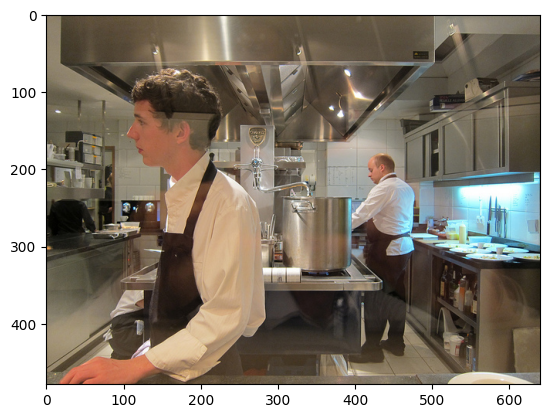

In [35]:
import matplotlib.pyplot as plt
plt.imshow(sample["image"])

In [36]:
gemma_tokenizer.special_tokens_map

{'bos_token': '<bos>',
 'eos_token': '<eos>',
 'unk_token': '<unk>',
 'pad_token': '<pad>',
 'boi_token': '<start_of_image>',
 'eoi_token': '<end_of_image>',
 'image_token': '<image_soft_token>'}

In [37]:
gen

tensor([[   506, 236743, 236770, 236819, 236825, 236771, 236751, 236764,    506,
         236743, 236770, 236819, 236832, 236771, 236751, 236764,    532,    506,
         236743, 236770, 236819, 236828, 236771, 236751, 236761, 255999, 255999,
         255999, 255999, 255999]], device='cuda:0')

In [41]:
inputs_embeds.argmax(dim=2)

tensor([[488, 364, 135, 135, 513, 513, 513, 135, 488, 488, 488,  96, 135,  96,
         135, 488, 513, 513, 135, 513, 513, 513, 488, 488, 135, 135, 135, 135,
         513, 513, 513, 513, 513, 513, 135, 513,  26, 488, 488,  96, 488, 488,
         488, 513, 513, 513, 513, 513, 513, 414,  21, 471, 488, 488, 488, 488,
         135, 513, 513, 513, 513, 513, 513,  21, 625, 471, 513, 135, 488, 488,
         513, 513, 513, 513, 513, 513, 513, 513, 625, 233, 488, 135, 488, 513,
         471, 513, 513, 513, 513, 513, 513, 513,  21, 135, 233, 135, 135, 513,
         135, 135, 513, 513, 513, 594, 513, 135, 135,  15, 233, 488, 488, 488,
         135, 135, 513, 513, 513, 135, 513, 513, 214, 135, 135, 488, 488, 488,
         488, 513, 513, 513,  42, 135, 513, 135, 488, 135,  96, 488, 488, 488,
         488, 513, 513, 513, 513, 135, 488, 513, 488, 135,  96, 488, 488, 488,
         488, 488, 513, 488, 488, 135, 135, 488, 488,  96,  96, 488, 488, 488,
         488, 488, 135, 488, 488, 135, 135, 488, 513

In [42]:
# Let's re-tokenize the prompt to see its token IDs and length
prompt = "In this image:"
prompt_tok = gemma_tokenizer(prompt, return_tensors="pt")
prompt_ids = prompt_tok["input_ids"].to(device)

print("Prompt string:", prompt)
print("Prompt token IDs:", prompt_ids)
print("Number of prompt tokens:", prompt_ids.shape[1])

# Recall the size of the image prefix from cell Tgfwe-_ajSvS
# prefix.shape[1] was 201 for the dummy image batch
# The start_idx was calculated as prefix.shape[1] + prompt_ids.shape[1]

# Let's recalculate start_idx based on the actual prompt and prefix size
prefix_size = prefix.shape[1] # Get prefix size from the last generation run
start_idx_calculated = prefix_size + prompt_ids.shape[1]

print("Image prefix size (number of tokens):", prefix_size)
print("Calculated start_idx:", start_idx_calculated)

# Now let's look at the 'gen' tensor again (from cell _qT7z_sPyvVZ)
# gen shape was torch.Size([1, 30])

print("\n'gen' tensor shape:", gen.shape)

# Decode the portion of 'gen' that should be the prompt + generated tokens
# This should start after the conceptual "image prefix" part
# The gen tensor's indices correspond to the tokens AFTER the image prefix embeddings
# So, the prompt tokens are at the beginning of the gen tensor
decoded_gen_full = gemma_tokenizer.batch_decode(gen, skip_special_tokens=True)[0]
print("\nDecoded 'gen' tensor (full):", decoded_gen_full)

# Let's try to decode just the part that should be the prompt
# Assuming the prompt tokens are at the beginning of the gen tensor
num_prompt_tokens = prompt_ids.shape[1]
decoded_prompt_from_gen = gemma_tokenizer.batch_decode(gen[:, :num_prompt_tokens], skip_special_tokens=True)[0]
print(f"\nDecoded first {num_prompt_tokens} tokens from 'gen' (should be prompt):", decoded_prompt_from_gen)

# And decode the generated part (after the prompt)
decoded_generated_from_gen = gemma_tokenizer.batch_decode(gen[:, num_prompt_tokens:], skip_special_tokens=True)[0]
print(f"\nDecoded tokens from 'gen' after prompt (should be generated):", decoded_generated_from_gen)

Prompt string: In this image:
Prompt token IDs: tensor([[     2,    902,    672,   2471, 236787]], device='cuda:0')
Number of prompt tokens: 5
Image prefix size (number of tokens): 201
Calculated start_idx: 206

'gen' tensor shape: torch.Size([1, 30])

Decoded 'gen' tensor (full):  the 1960s, the 1970s, and the 1980s.

Decoded first 5 tokens from 'gen' (should be prompt):  the 196

Decoded tokens from 'gen' after prompt (should be generated): 0s, the 1970s, and the 1980s.


In [4]:
gemma_tokenizer.all_special_tokens_extended

[AddedToken("<bos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 AddedToken("<eos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 '<start_of_image>',
 '<end_of_image>',
 '<image_soft_token>']

In [4]:
gemma_tokenizer.special_tokens_map

{'bos_token': '<bos>',
 'eos_token': '<eos>',
 'unk_token': '<unk>',
 'pad_token': '<pad>',
 'boi_token': '<start_of_image>',
 'eoi_token': '<end_of_image>',
 'image_token': '<image_soft_token>'}

In [5]:
gemma_tokenizer.boi_token_id

255999